# LSTM Time Series

Neste notebook veremos como podemos usar a arquitetura [Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) para previsões de séries temporais.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Começaremos gerando os dados:

In [2]:
series = np.sin((0.1*np.arange(400))**2)

Esta é uma série temporal na forma:

$$ x(t) = \sin(\omega t^2) $$

Vamos plotar os dados para visualização:

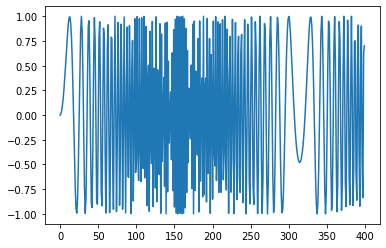

In [3]:
plt.plot(series);

Construímos o conjunto de dados.

Vejamos se podemos usar T valores anteriores para prever o próximo valor:

In [4]:
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # make it N x T
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


Setamos o dispositivo de processamento disponível:

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Definimos a RNN (usando LSTM):

In [6]:
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        # note: batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc =nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, (h0, c0))

        # we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

Instanciamos o modelo:

In [7]:
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

Definimos a função Loss e o Otimizador:

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

Dividimos os dados em treinamento e teste:

In [9]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

Encapsulamos o procedimento de treinamento em uma função:

In [10]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
            
        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
            
        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

Movemos os dados para o dispositivo de processamento:

In [11]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

Treinamos o modelo:

In [12]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/200, Train Loss: 0.5427, Test Loss: 0.4923
Epoch 10/200, Train Loss: 0.5117, Test Loss: 0.5239
Epoch 15/200, Train Loss: 0.4964, Test Loss: 0.6295
Epoch 20/200, Train Loss: 0.4821, Test Loss: 0.6587
Epoch 25/200, Train Loss: 0.4281, Test Loss: 0.5641
Epoch 30/200, Train Loss: 0.3580, Test Loss: 0.5445
Epoch 35/200, Train Loss: 0.2471, Test Loss: 0.3744
Epoch 40/200, Train Loss: 0.0929, Test Loss: 0.2339
Epoch 45/200, Train Loss: 0.0529, Test Loss: 0.1162
Epoch 50/200, Train Loss: 0.0357, Test Loss: 0.0893
Epoch 55/200, Train Loss: 0.0304, Test Loss: 0.0743
Epoch 60/200, Train Loss: 0.0241, Test Loss: 0.0709
Epoch 65/200, Train Loss: 0.0169, Test Loss: 0.0630
Epoch 70/200, Train Loss: 0.0138, Test Loss: 0.0483
Epoch 75/200, Train Loss: 0.0104, Test Loss: 0.0416
Epoch 80/200, Train Loss: 0.0086, Test Loss: 0.0382
Epoch 85/200, Train Loss: 0.0070, Test Loss: 0.0322
Epoch 90/200, Train Loss: 0.0058, Test Loss: 0.0325
Epoch 95/200, Train Loss: 0.0050, Test Loss: 0.0321
Epoch 100/200

Plotamos o loss de treinamento e teste por iteração:

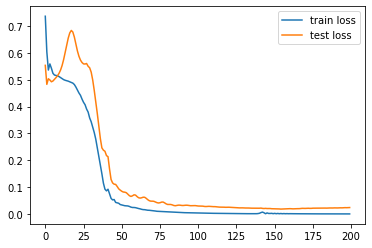

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

Executamos a previsão de uma etapa usando True Targets:

In [14]:
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

Plotamos o resultado da previsão:

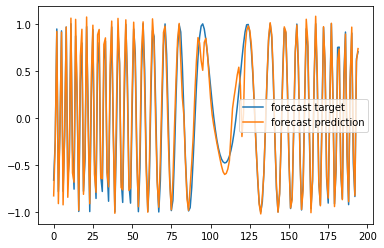

In [15]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

Executamos a previsão de múltiplas etapas:

In [16]:
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

Plotamos o resultado da previsão:

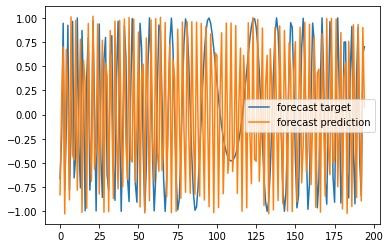

In [17]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();